# Import Libraries

The below block imports all needed libraries. Feel free to add additional libraries that you need and rerun below block.

Two last lines inform you of the Pytorch version and the availability of GPU.
The last line should print `GPU availability: True`.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from tqdm import tqdm

print('Pytorch version: ', torch.__version__)
print('GPU availability: ', torch.cuda.is_available())

Pytorch version:  1.12.1+cu113
GPU availability:  True


# Download Dataset
If you are familiar with Linux bash scripts, you can put `!` at the beginning of a command to order Colab of interpreting it as bash scripts instead of python scripts.

The below block downloads MNIST dataset and decompresses it.

In [2]:
!wget https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
!tar xzf mnist_png.tar.gz

--2022-11-19 15:52:39--  https://github.com/myleott/mnist_png/raw/master/mnist_png.tar.gz
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz [following]
--2022-11-19 15:52:39--  https://raw.githubusercontent.com/myleott/mnist_png/master/mnist_png.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15683414 (15M) [application/octet-stream]
Saving to: ‘mnist_png.tar.gz.1’

mnist_png.tar.gz.1  100%[===================>]  14.96M  --.-KB/s    in 0.07s   

2022-11-19 15:52:39 (200 MB/s) - ‘mnist_png.tar.gz.1’ saved [15683414/15683414]



# Define Dataset Class

**TODO1:** Complete ```def apply_noise(self, im)``` to add a Gaussian noise of $\mathcal{N}(0, 0.5)$ (mean of 0 and standard derivative of 0.5).

**TODO1**

In [3]:
# Define Dataset:
class MNISTDataset(Dataset):
    def __init__(self, root, transform=None):
        # `root` is expected to contain 10 sub-directories, each of which is named after the label of all images included inside.
        # transform is a Torchvision.Transforms object that pre-processes an image 
        self.root = root
        self.transform = transform
    
        self.images = list()

        for label in os.listdir(root):
            subdir = os.path.join(root, label)
            for im_name in os.listdir(subdir):
                im = plt.imread(os.path.join(subdir, im_name))
                self.images.append(im)
        self.dataset_size = len(self.images)

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, index):
        im = self.transform(self.images[index]) if self.transform is not None else self.images[index]
        noised_im = self.apply_noise(im)
        return noised_im, im

    def apply_noise(self, im):
        #TODO1: Add gaussian noise to the input image `im`.
        mean     = 0
        stdev    = 0.5
        gauss_noise = torch.randn_like(im)*stdev+mean
        noisy_im = im + gauss_noise
        return noisy_im

    def show_random(self, num_samples=8):
        indices = np.random.randint(0, len(self), [num_samples,])
        f, ax = plt.subplots(num_samples, 2, figsize=(10, 10))
        for i in range(num_samples):
            noised_im, im = self[indices[i]]
            ax[i, 0].imshow(im[0].numpy())
            ax[i, 1].imshow(noised_im[0].numpy())
        plt.show()


# Create MNISTDataset objects and dataloaders 
Below, we create the objects to process training and testing sets of MNIST data.
As there are no held-out validation set, we manually split the training set into training and validation subsets with the ratio of 8:2.

After creating dataset objects, we wrap them by a Pytorch Dataloader to allow several necessary features in training deep learning models, e.g., mini-batch feeding, shuffling.

***Note***: if you successfully complete `__init__` function of `MNISTDataset`, its `show_random` function would successfully randomly show 8 images and corresponding noisy images in the dataset.

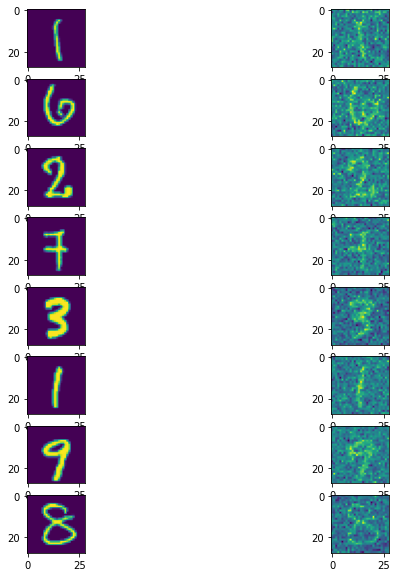

Training set size:  48000
Validation set size:  12000
Testing set size:  10000


In [4]:
################################################################
# Hyper parameters
################################################################
BATCH_SIZE = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

################################################################
# Create training and testing dataset and show random examples
################################################################
trainval_set = MNISTDataset('mnist_png/training', transform=transform)
trainval_set.show_random()

test_set = MNISTDataset('mnist_png/testing', transform=transform)

################################################################
# As there is no validation set
# We split training dataset into training and validation sets
################################################################
train_size = int(0.8 * len(trainval_set))
val_size = len(trainval_set) - train_size
train_set, val_set = torch.utils.data.random_split(
    dataset=trainval_set,
    lengths=[train_size, val_size],
    generator=torch.Generator().manual_seed(42))

################################################################
# Print lengths of subsets
################################################################
print('Training set size: ', len(train_set))
print('Validation set size: ', len(val_set))
print('Testing set size: ', len(test_set))

################################################################
# Print lengths of subsets
################################################################
train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=BATCH_SIZE,
    shuffle=True)
val_loader = torch.utils.data.DataLoader(
    dataset=val_set,
    batch_size=BATCH_SIZE,
    shuffle=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=BATCH_SIZE,
    shuffle=False)

#TODO2: Create Autoencoder network based on MLP

Create an Autoencoder with an encoder and a decoder that are MLPs following the below descriptions:

- Encoder: 3 linear layers of 512, 128, 128 perceptrons. The first two layers having ReLU activation function, and the last layer do **NOT** have activation function.

- Decoder: 4 linear layers of 128, 128, 512, 28\*28 perceptrons. The first two layers having ReLU activation function, and the last layer do **NOT** have activation function.

The Encoder will process the noisy input image of size 28x28 from MNIST and encode it into a 128-dimension vector.

Then, the Decoder will process the 128-dimension vector from Encoder and decode it into 28x28 image.

# TODO3: Implement the training, validating and testing processes

The network should be trained on training set following below descriptions:
- Number of epochs: 100
- Learning rate: 0.0001
- Optimizer: AdamW
- Loss function: L1 Loss

After each epoch, evaluate the model on validation set and save the best performed model to a checkpoint. Eventually, please load the best checkpoint and test it on testing set.

Please plot a graph showing the training progress, which should include two line plots for training loss and validation loss at every epoch.

# TODO4: Change loss function to L2 Loss (Mean squared error)

Please follow the training and testing requirements as in **TODO3**. Then, plot a graph showing the training progress, which should include two line plots for training loss and validation loss at every epoch.

**TODO2**

In [5]:
#TODO 2
#Defining the AutoEncoder
class Denoising_model(nn.Module):
  def __init__(self):
    super(Denoising_model,self).__init__()
    self.Encoder=nn.Sequential(
                  nn.Linear(28*28,512),
                  nn.ReLU(True),
                  nn.Linear(512,128),
                  nn.ReLU(True),
                  nn.Linear(128,128)
                  )
    
    self.Decoder=nn.Sequential(
                  nn.Linear(128,128),
                  nn.ReLU(True),
                  nn.Linear(128,128),
                  nn.ReLU(True),
                  nn.Linear(128,512),
                  nn.ReLU(True),
                  nn.Linear(512, 28*28)
                  )
    
 
  def forward(self,x):
    x=self.Encoder(x)
    x=self.Decoder(x)
    
    return x

In [6]:
if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

**TODO3**

In [7]:
#Hyperparameters
lrate     = 0.0001
epochs    = 100
model     = Denoising_model()
model     = model.to(device)
criterion = nn.L1Loss()
optimizer = optim.AdamW(model.parameters(),lr=lrate)

In [8]:
#Path to save best model
model_dir = "Best_Model"
model_name = "L1_model.pt"
try: 
    if os.path.exists(model_dir) == False:
        os.mkdir(model_dir)
except OSError as error: 
    print(error)
model_path = model_dir+"/"+model_name


In [9]:
tr_size       = len(train_loader)
val_size      = len(val_loader)
tr_loss_list  = list()
val_loss_list = list()
epoch_list    = list()
best_val_loss = 1000

for epoch in range(epochs):
  tr_running_loss  = 0
  val_running_loss = 0
  print("Entering Epoch: ",epoch+1)
  #Training
  for batch_idx, (dirty, clean) in enumerate(train_loader):  
    dirty       = dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean       = clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean = dirty.to(device),clean.to(device)

    output      = model(dirty)
    loss        = criterion(output,clean)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    tr_running_loss += loss.item()
  #-----------------Train Log-----------------------------
  tr_avg_loss = tr_running_loss/tr_size
  tr_loss_list.append(tr_avg_loss)

  #Validation
  with torch.no_grad():
    for batch_idx, (dirty, clean) in enumerate(val_loader):  
      dirty             = dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
      clean             = clean.view(clean.size(0),-1).type(torch.FloatTensor)
      dirty,clean       = dirty.to(device),clean.to(device)

      output            = model(dirty)
      loss              = criterion(output,clean)      
      val_running_loss += loss.item()
    #-----------------Validation Log-----------------------------
    val_avg_loss = val_running_loss/val_size
    val_loss_list.append(val_avg_loss)
    epoch_list.append(epoch+1)
    #saving best performing model under L1 loss
    if best_val_loss>val_avg_loss:
      best_val_loss = val_avg_loss
      torch.save(model.state_dict(), model_path)

  print("======> Epoch: {}/{}, L1 Train average loss:{:.6f}, Validation average loss:{:.6f}".format(epoch+1,epochs,tr_avg_loss, val_avg_loss))
print("Best loss: {:.6f}".format(best_val_loss) )

Entering Epoch:  1
======> Epoch: 1/100, L1 Train average loss:0.166180, Validation average loss:0.134174
Entering Epoch:  2
======> Epoch: 2/100, L1 Train average loss:0.131796, Validation average loss:0.129945
Entering Epoch:  3
======> Epoch: 3/100, L1 Train average loss:0.123122, Validation average loss:0.118337
Entering Epoch:  4
======> Epoch: 4/100, L1 Train average loss:0.113484, Validation average loss:0.111052
Entering Epoch:  5
======> Epoch: 5/100, L1 Train average loss:0.108259, Validation average loss:0.106737
Entering Epoch:  6
======> Epoch: 6/100, L1 Train average loss:0.104554, Validation average loss:0.102442
Entering Epoch:  7
======> Epoch: 7/100, L1 Train average loss:0.099880, Validation average loss:0.097943
Entering Epoch:  8
======> Epoch: 8/100, L1 Train average loss:0.096007, Validation average loss:0.094764
Entering Epoch:  9
======> Epoch: 9/100, L1 Train average loss:0.093445, Validation average loss:0.092649
Entering Epoch:  10
======> Epoch: 10/100, L1 

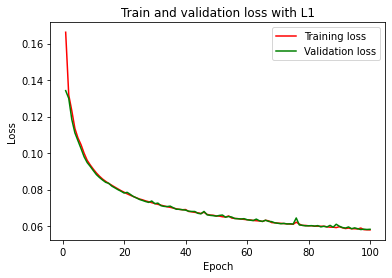

In [10]:
# Training and validation plots
plt.plot(epoch_list, tr_loss_list, color='r', label='Training loss')
plt.plot(epoch_list, val_loss_list, color='g', label='Validation loss')
  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss with L1")
plt.legend()
plt.show()

In [11]:
#Testing the model
#loading the best model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

Denoising_model(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

======>L1 Test average loss:0.057382


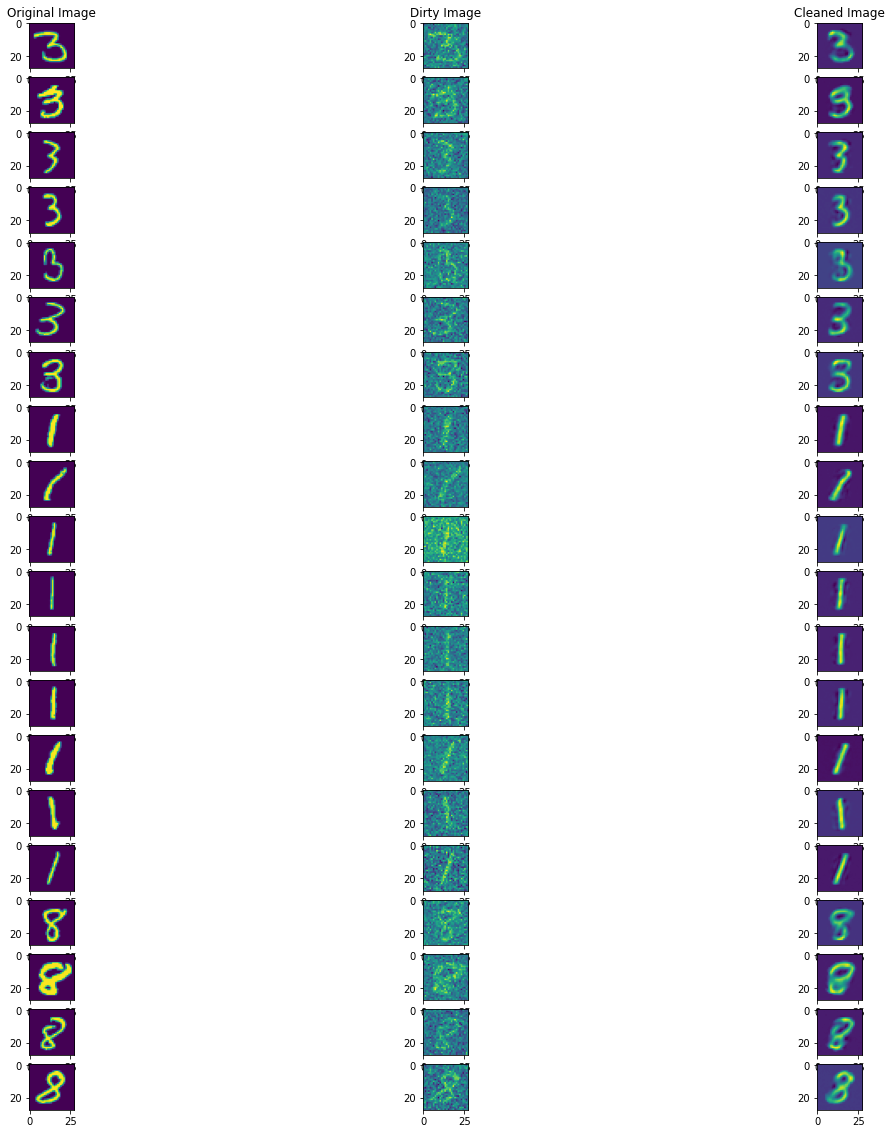

In [12]:
#Testing
img_count      = 0
test_running_loss = 0
f,axes= plt.subplots(20,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

plots = 0
with torch.no_grad():
  for batch_idx, (dirty_t, clean_t) in enumerate(test_loader): 
    length = len(dirty_t)
    for idx in range (length):
      img_count += 1
      dirty=dirty_t[idx]
      clean=clean_t[idx]
      clean_plot = clean
      dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
      clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
      dirty,clean=dirty.to(device),clean.to(device)

      output=model(dirty)

      loss=criterion(output,clean)      
      test_running_loss+=loss.item()
        
      output=output.view(1,28,28)
      output=output.permute(1,2,0).squeeze(2)
      output=output.detach().cpu().numpy()
      
      dirty=dirty.view(1,28,28)
      dirty=dirty.permute(1,2,0).squeeze(2)
      dirty=dirty.detach().cpu().numpy()
      
      clean=clean_plot.permute(1,2,0).squeeze(2)
      clean=clean.detach().cpu().numpy()
      if idx == length-1 and batch_idx < 20 :
        axes[plots,0].imshow(clean)
        axes[plots,1].imshow(dirty)
        axes[plots,2].imshow(output)
        plots += 1
      
#-----------------Test Log-----------------------------
test_avg_loss = test_running_loss/img_count
print("======>L1 Test average loss:{:.6f}".format(test_avg_loss))

**TODO4**

In [13]:
lrate = 0.0001
epochs = 100
model=Denoising_model().to(device)
criterion = nn.MSELoss()
optimizer=optim.AdamW(model.parameters(),lr=lrate)

In [14]:
# Path to save best model
model_name = "L2_model.pt"
model_path = model_dir+"/"+model_name

In [15]:
tr_size       = len(train_loader)
val_size      = len(val_loader)
tr_loss_list  = list()
val_loss_list = list()
epoch_list    = list()
best_val_loss = 1000

for epoch in range(epochs):
  tr_running_loss=0
  val_running_loss = 0
  print("Entering Epoch: ",epoch+1)
  #Training
  for batch_idx, (dirty, clean) in enumerate(train_loader):  
    dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
    clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
    dirty,clean=dirty.to(device),clean.to(device)

    #-----------------Forward Pass----------------------
    output=model(dirty)
    loss=criterion(output,clean)
    #-----------------Backward Pass---------------------
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    tr_running_loss+=loss.item()
  #-----------------Train Log-----------------------------
  tr_avg_loss = tr_running_loss/tr_size
  tr_loss_list.append(tr_avg_loss)

  #Validation
  with torch.no_grad():
    for batch_idx, (dirty, clean) in enumerate(val_loader):  
      dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
      clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
      dirty,clean=dirty.to(device),clean.to(device)

      output=model(dirty)
      loss=criterion(output,clean)      
      val_running_loss+=loss.item()
    #-----------------Validation Log-----------------------------
    val_avg_loss = val_running_loss/val_size
    val_loss_list.append(val_avg_loss)
    epoch_list.append(epoch+1)
    #saving best performing model under L1 loss
    if best_val_loss>val_avg_loss:
      best_val_loss = val_avg_loss
      torch.save(model.state_dict(), model_path)

  print("======> epoch: {}/{}, L2 Train average loss:{:.6f}, Val average loss:{:.6f}".format(epoch+1,epochs,tr_avg_loss, val_avg_loss))
print("Best loss: {:.6f}".format(best_val_loss) )

Entering Epoch:  1
======> epoch: 1/100, L2 Train average loss:0.075769, Val average loss:0.050668
Entering Epoch:  2
======> epoch: 2/100, L2 Train average loss:0.043250, Val average loss:0.038311
Entering Epoch:  3
======> epoch: 3/100, L2 Train average loss:0.035653, Val average loss:0.033696
Entering Epoch:  4
======> epoch: 4/100, L2 Train average loss:0.032080, Val average loss:0.030851
Entering Epoch:  5
======> epoch: 5/100, L2 Train average loss:0.029730, Val average loss:0.028895
Entering Epoch:  6
======> epoch: 6/100, L2 Train average loss:0.028140, Val average loss:0.027539
Entering Epoch:  7
======> epoch: 7/100, L2 Train average loss:0.026974, Val average loss:0.026522
Entering Epoch:  8
======> epoch: 8/100, L2 Train average loss:0.026013, Val average loss:0.025746
Entering Epoch:  9
======> epoch: 9/100, L2 Train average loss:0.025261, Val average loss:0.024967
Entering Epoch:  10
======> epoch: 10/100, L2 Train average loss:0.024606, Val average loss:0.024383
Entering

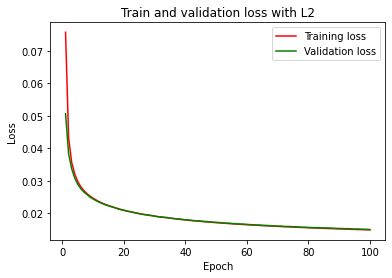

In [16]:
# Training and validation plots
plt.plot(epoch_list, tr_loss_list, color='r', label='Training loss')
plt.plot(epoch_list, val_loss_list, color='g', label='Validation loss')
  
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and validation loss with L2")
plt.legend()
plt.show()

In [19]:
#Testing the model
#loading the best model
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint)
model.eval()

Denoising_model(
  (Encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (Decoder): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=512, out_features=784, bias=True)
  )
)

======>L2 Test average loss:0.014766


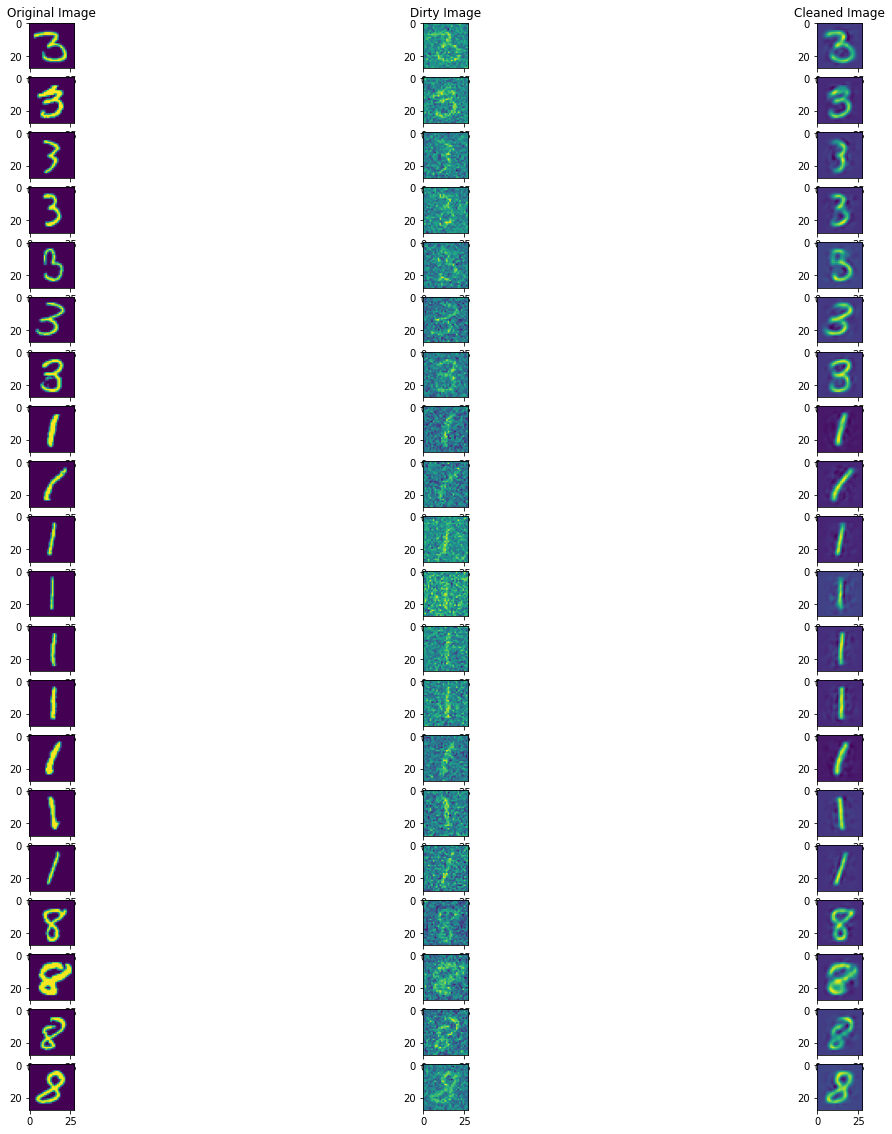

In [18]:
#Testing
#test_size        = len(test_loader)
img_count      = 0
test_running_loss = 0
f,axes= plt.subplots(20,3,figsize=(20,20))
axes[0,0].set_title("Original Image")
axes[0,1].set_title("Dirty Image")
axes[0,2].set_title("Cleaned Image")

plots = 0
with torch.no_grad():
  for batch_idx, (dirty_t, clean_t) in enumerate(test_loader): 
    length = len(dirty_t)
    for idx in range (length):
      img_count += 1
      dirty=dirty_t[idx]
      clean=clean_t[idx]
      clean_plot = clean
      dirty=dirty.view(dirty.size(0),-1).type(torch.FloatTensor)
      clean=clean.view(clean.size(0),-1).type(torch.FloatTensor)
      dirty,clean=dirty.to(device),clean.to(device)

      output=model(dirty)

      loss=criterion(output,clean)      
      test_running_loss+=loss.item()
        
      output=output.view(1,28,28)
      output=output.permute(1,2,0).squeeze(2)
      output=output.detach().cpu().numpy()
      
      dirty=dirty.view(1,28,28)
      dirty=dirty.permute(1,2,0).squeeze(2)
      dirty=dirty.detach().cpu().numpy()
      
      clean=clean_plot.permute(1,2,0).squeeze(2)
      clean=clean.detach().cpu().numpy()
      if idx == length-1 and batch_idx < 20 :
        axes[plots,0].imshow(clean)
        axes[plots,1].imshow(dirty)
        axes[plots,2].imshow(output)
        plots += 1
      
#-----------------Test Log-----------------------------
test_avg_loss = test_running_loss/img_count
print("======>L2 Test average loss:{:.6f}".format(test_avg_loss))